# Word Level OCR for Persian Language
## Based on Recurrent Neural Networks
Amirabbas Asadi, amir137825@gmail.com

## Requirements
- Pandas, Numpy, Scikit-Learn
- Pytorch
- OpenCV
- imgaug

## Dataset
I created a Synthetic dataset called Shotor containing 120000 images and correspond words.  
[Download The Dataset](https://github.com/amirabbasasadi/Shotor)

## Loading and using images

In [1]:
from imgaug import augmenters as iaa
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import seaborn as sns
sns.set()
sns.set_style('dark')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from random import randint

### Some configurations

In [26]:
# input images width
img_width = 100
# input images height
img_height = 50
# every image will be splited into <img_splits> parts
img_splits = 20
# maximum length of each word
word_max_len = 15
# device for tensors
# current version is sequential and GPU has not a significant effect
# I didn't test the model on GPU 
device = 'cpu' 

### Set dataset path

In [90]:
dataset_path = 'enter dataset path here'
csv_words_path = 'enter words csv path here'

### Creating dataset object
It is easier to define a dataset object for using data for Pytorch models

In [28]:
class PersianOCR(Dataset):
    """Persian Hand-Written dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # read the csv file
        self.csv = pd.read_csv(csv_file)
    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        word = self.csv.iloc[idx, 1]
        image = io.imread(img_name)
        
        item = {'image': image, 'word': word}

        if self.transform:
            item = self.transform(item)

        return item

dataset = PersianOCR(csv_words_path, dataset_path)

### Checking the raw dataset
Take a look at some random words from dataset

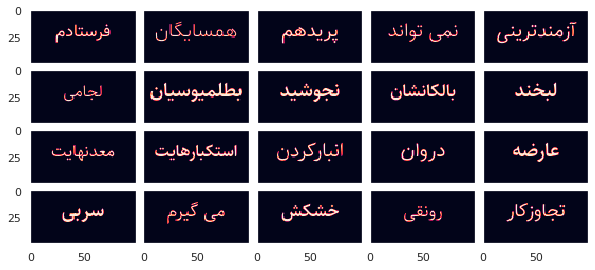

In [29]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  images.append(dataset[randint(0, len(dataset)-1)]['image'])

for ax, im in zip(grid, images):
    ax.imshow(im)
plt.show()

### Converting Words and Images to Pytorch Tensors
We should define all persian alphabets.
Also we define `S` as start token and `E` as end token and `-` as blank character which is used for CTCLoss that we wanna use and is different from space character.

In [30]:
# define all persian alphabets
pchars = "آ ا ب پ ت ث ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی ئ"
pchars = ['-',' ', 'S', 'E'] + pchars.split(' ')
letter_to_index = {}
for i in range(len(pchars)):
  letter_to_index[pchars[i]] = i
enc_dim = len(pchars)

In [31]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        image = image.reshape(-1, img_height, img_width)
        if (len(word) > word_max_len):
          word = word[:word_max_len]
        word = word + 'E'
        original_word = [[letter_to_index[c]] for c in word]
        return {'image': torch.from_numpy(image).double(),
                'word' : torch.LongTensor(original_word)}

### Augmentation Pipeline
using imgaug we can define an Augmentation pipeline. It helps to train a robust model and useable for more realistic data. It randomly applies some of 5 augmentations.

In [32]:
class ImageAug(object):
    """Apply Image Augmentation on style and output"""

    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        aug = iaa.SomeOf((0, 5), [
            iaa.Affine(scale={"x": (0.80, 1.20), "y": (0.80, 1.20)}),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
            iaa.Add((-30, 30)),
            iaa.Multiply((0.80, 1.20)),
            iaa.GaussianBlur(sigma=(0, 0.2))
        ])
        image = aug(images=image)
        return {'image': image,
                'word': word}


### Create Dataset with Transformations

In [33]:
transformed_dataset = PersianOCR(csv_words_path, dataset_path,
                                 transform=transforms.Compose([ImageAug(), ToTensor()]))

dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle=True)

### See some samples from transformed dataset

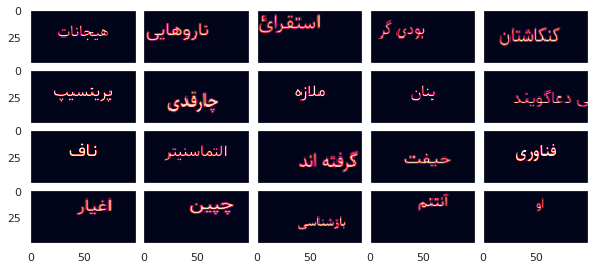

In [35]:
dataiter = iter(dataloader)

fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  batch = dataiter.next()
  images.append(batch['image'][0][0])

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

## Defining a Recurrent Neural Network in Pytorch

In [46]:
import torch.nn as nn

class OCRNet(nn.Module):
    def __init__(self, img_size, hidden_size):
        super(OCRNet, self).__init__()
        self.hidden_size = hidden_size
        self.img_size = img_size
        self.enc_img_size = 200
        self.fc1 = nn.Linear(self.img_size, 450)
        self.fc2 = nn.Linear(450, self.enc_img_size)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.CELU()
        self.i2h = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 80)
        self.h2h = nn.Linear(80, 60)
        self.h2h2 = nn.Linear(60, self.hidden_size)
        self.i2o = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 200)
        self.o2o = nn.Linear(200, enc_dim)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x, input, hidden):
        x = x.reshape((1, -1))
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.drop(x)
        combined = torch.cat((x, input.view((1, -1)), hidden.view((1, -1))), 1)
        hidden = self.act(self.i2h(combined))
        hidden = self.act(self.h2h(hidden))
        hidden = self.h2h2(hidden)
        output = self.act(self.i2o(combined))
        output = self.o2o(output)
        output = self.softmax(output)
        
        return output, hidden


net = OCRNet(int(img_width/img_splits)*img_height, enc_dim).double()
net = net.to(device)
print(net)
print("Number of Parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

OCRNet(
  (fc1): Linear(in_features=250, out_features=450, bias=True)
  (fc2): Linear(in_features=450, out_features=200, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (act): CELU(alpha=1.0)
  (i2h): Linear(in_features=276, out_features=80, bias=True)
  (h2h): Linear(in_features=80, out_features=60, bias=True)
  (h2h2): Linear(in_features=60, out_features=38, bias=True)
  (i2o): Linear(in_features=276, out_features=200, bias=True)
  (o2o): Linear(in_features=200, out_features=38, bias=True)
  (softmax): LogSoftmax()
)
Number of Parameters:  295526


## Training The Model

### Generating start token

In [47]:
def get_start_token():
  start_token = torch.zeros((1, enc_dim), dtype=torch.double).to(device)
  start_token[0][letter_to_index['S']] = 1
  return start_token

### Defining Optimizer

In [48]:
import torch.optim as optim

# I suggest to decrease the learning rate after each epoch
# for the first one I used lr = 0.0002 and for the second lr = 0.00005
optim_learning_rate = 0.0002

criterion = nn.CTCLoss() 
optimizer = optim.Adam(net.parameters(), lr=optim_learning_rate, betas=(0.5, 0.999))

epochs = 1
mini_batchs = 100
loss_values = []

### Training
After two epochs I saw an acceptable output. on CPU each epoch might take 1-2 hours.

In [49]:
net.train()
step = int(img_width / img_splits)
input_seq_len = torch.tensor([img_splits], dtype=torch.long)
for epoch in range(epochs):
    loss = 0
    mini_batch_loss = 0
    for i, data in enumerate(dataloader, 0):
        # get the input
        image, word = data['image'], data['word']
        image = image.to(device)
        word = word.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # initialize the RNN hidden state
        hidden = torch.zeros((1, enc_dim)).double().to(device)
        output = get_start_token()
        letters = []
        for j in range(img_splits):
          output, hidden = net(image[:, :, :,
                                     step*(img_splits-j-1):step*(img_splits-j)],
                                     output, hidden)
          letters.append(output)

        # concatinate the outputs
        predicted_word = torch.cat(letters, dim=1).view(img_splits, 1, enc_dim)
        
        target_seq_len = torch.tensor([word.size(1)],
                                      dtype=torch.long)
        
        # compairing the output and word based on CTCLoss
        loss = criterion(predicted_word, word.view((1, -1)),
                          input_seq_len, target_seq_len)
        
        loss_values.append(loss.item())    
        
        loss.backward()
        
        optimizer.step()
        
        mini_batch_loss += loss.item()
        
        if i % mini_batchs == (mini_batchs-1):
            
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, mini_batch_loss/mini_batchs))
            
            mini_batch_loss = 0
            if(i > 500):
                break

[1,   100] loss: 4.77067
[1,   200] loss: 3.27652
[1,   300] loss: 3.09982
[1,   400] loss: 3.08970
[1,   500] loss: 3.08127
[1,   600] loss: 2.84055


### Checking The Loss values

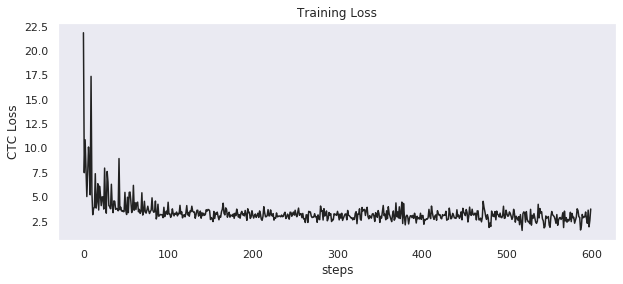

In [51]:
sns.set_palette(sns.dark_palette("purple"))
fig, ax = plt.subplots(figsize=(10, 4))
plot = sns.lineplot(ax=ax,y=loss_values, x=range(len(loss_values)))
plot.set_title("Training Loss")
plot.set_xlabel("steps")
plot.set_ylabel("CTC Loss")
plt.show()

## Using The Model for converting a page

### Cleaning The Ouput
Due to the CTCLoss we should clear the ouput from repeated characters then `-` (blank) characters. 

In [52]:
import re
def clean_ctc(s):
    # remove repeated
    word = ""
    prev = ""
    for c in s:
      if(c != prev):
        word += c
      prev = c
    word = re.sub('[\-SE]', '', word)
    return word

### Converting Output Tensor To Word

In [53]:
def tensor_to_word(word_tensor):
    word_tensor = word_tensor.max(2)[1].view(-1)
    word = ""
    for i in range(word_tensor.size(0)):
      word += pchars[word_tensor[i]]
    return clean_ctc(word)

### Transforming Numpy Images for evaluation

In [54]:
def transform_numpy_image(img):
    # scale the image
    img = img.reshape(1, 1, 50, 100)
    tensor = torch.from_numpy(img).double().to(device)
    return tensor

### Feeding Image to Model 

In [55]:
def image_to_word(img):
    tensor = transform_numpy_image(img)
    prediction = None
    net.eval()
    with torch.no_grad():
      hidden = torch.zeros((1, enc_dim)).double().to(device)
      output = get_start_token()
      letters = []
      for j in range(img_splits):
        step = int(img_width / img_splits)
        output, hidden = net(tensor[:, :, :, step*(img_splits-j-1):step*(img_splits-j)], output, hidden)
        letters.append(output)
      prediction = torch.cat(letters, dim=0).view(img_splits, 1, enc_dim)
    return tensor_to_word(prediction)

### Reading The Text Image

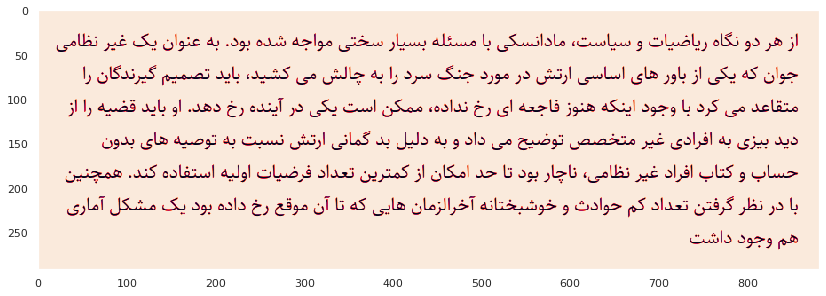

In [79]:
import cv2
%matplotlib inline
image_path = 'test_page.png'

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

### Thresholding The Image

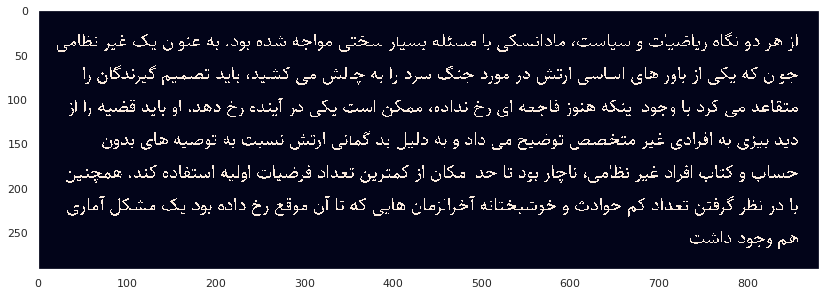

In [81]:
ret,thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(thresh, interpolation='nearest')

### Using dilation to segment the words

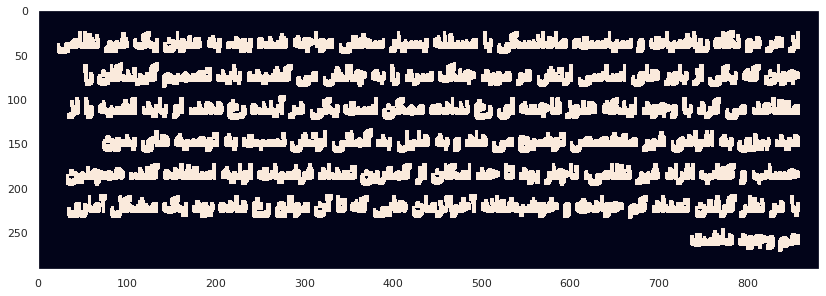

In [84]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 3))
dilation = cv2.dilate(thresh, rect_kernel, iterations = 3)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(dilation, interpolation='nearest')

### Finding The Contours

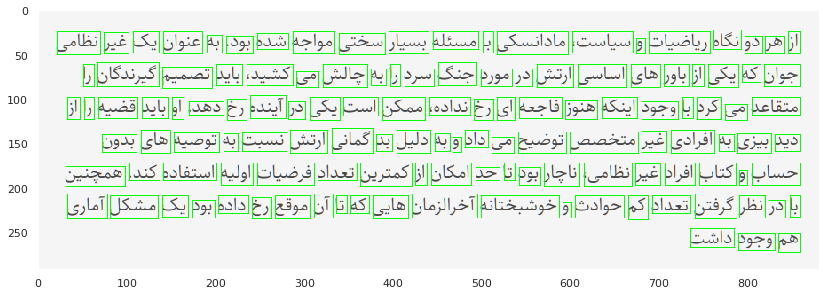

In [86]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
img_contours = img.copy()
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 255, 0), 1)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(img_contours, interpolation='nearest')

### Sorting The Contours

In [87]:
from functools import cmp_to_key

def rectCmp(r1, r2):
  if (abs(r1[1] - r2[1]) < 20):
    return r2[0] - r1[0]
  return r1[1] - r2[1]

bounding_rects = [ cv2.boundingRect(c) for c in contours ]
bounding_rects.sort(key=cmp_to_key(rectCmp))

### Extract Images

In [88]:
def extract_images(rects, image):
  images = []
  for r in rects:
    x, y, w, h = r
    H=50
    W=100
    Y = int((H-h)/2) - 5
    X = int((W-w)/2) - 5
    c = np.zeros((H, W))
    c[Y:Y+h, X:X+w] = 1-image[y:y+h, x:x+w]
    c[c < 70] = 0
    c *= 1.8
    c[c > 255] = 255
    c = np.floor(c)
    images.append(c)
  return images
test_images = extract_images(bounding_rects, gray)

## Final Result

In [89]:
' '.join([image_to_word(image) for image in test_images])

'م م ما منناه مریاا م مات مهای ما م میار مهایش مهنه م ماا من مهاهش میگ مر ماهی مهاری م م م ماهر مای ماری مرش ما مداا مهه ما مرا ما ماری مه می مای مانهه میرار مر ماهه مه مر ما مشنن مگ مان ماهه مهی منشی ما منر م م م مه منشی م م مای میه مرا م منها من ما ماانی مر مردرهن منهنش مه ما م من ماری مان مهاید مرر مه ما مهاهمهن مای مان ماه م ماه مرا مر ماره مانار مان ما م مناش م مرر ما مریاه مهایا ماها م مندشانمن ما م مر منر ما مه مهنن م میههاه مررهایش ممای م ما مر مهاج منی ما مان میگ م ماری منده مشننا ما'

## References
This paper helps me a lot, however my architecture is not same
- https://arxiv.org/abs/1805.09441
- [Pytorch Tutorial on RNNs](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)  
For word segmentation using dilation see this:
- https://stackoverflow.com/a/10970473/4334320

The text of the image which I used to show the final result is a translation of this book:
- The Theory That Would Not Die, Sharon McGrayne